Importation des librairies

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from itertools import product

import os
import pandas as pd
import numpy as np
import math
import datetime as dt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

##Visualisation Data

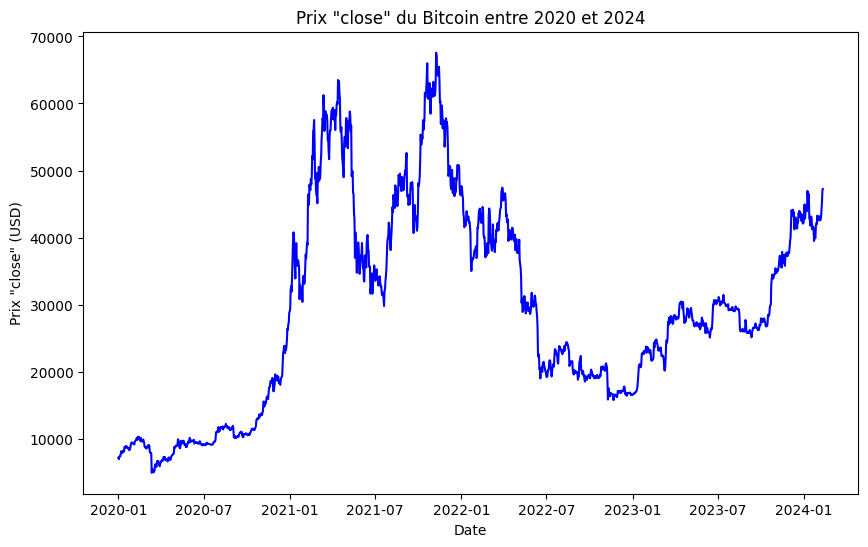

In [ ]:
# Charger les données depuis votre fichier CSV
df = pd.read_csv('/content/BTC-USD (1).csv')

# Convertir la colonne 'Date' en type datetime si elle n'est pas déjà convertie
df['Date'] = pd.to_datetime(df['Date'])

# Filtrez les données pour la période de 2020 à 2024
df_filtered = df[(df['Date'].dt.year >= 2020) & (df['Date'].dt.year <= 2024)]
# Créez le graphique
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['Date'], df_filtered['Close'], color='blue')

# Ajoutez des labels et un titre
plt.xlabel('Date')
plt.ylabel('Prix "close" (USD)')
plt.title('Prix "close" du Bitcoin entre 2020 et 2024')

# Affichez le graphe
plt.show()


# Partie I : LSTM et ARIMA


## I. A. LSTM

What is LSTM ?
Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points, but also entire sequences of data.
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning.
LSTMs are often referred to as fancy RNNs. Vanilla RNNs do not have a cell state. They only have hidden states and those hidden states serve as the memory for RNNs. Meanwhile, LSTM has both cell states and a hidden states.
image.

 Building LSTM Model



In [ ]:
# Import data
maindf = pd.read_csv('BTC-USD (1).csv')

# Check for missing values
print(maindf.isnull().sum())

# Print the first few rows of the dataframe
print(maindf)


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
            Date          Open          High           Low         Close  \
0     2016-01-01    430.721008    436.246002    427.515015    434.334015   
1     2016-01-02    434.622009    436.062012    431.869995    433.437988   
2     2016-01-03    433.578003    433.743011    424.705994    430.010986   
3     2016-01-04    430.061005    434.516998    429.084015    433.091003   
4     2016-01-05    433.069000    434.182007    429.675995    431.959991   
...          ...           ...           ...           ...           ...   
2958  2024-02-06  42657.390625  43344.148438  42529.019531  43084.671875   
2959  2024-02-07  43090.019531  44341.949219  42775.957031  44318.222656   
2960  2024-02-08  44332.125000  45575.839844  44332.125000  45301.566406   
2961  2024-02-09  45297.382813  48152.496094  45260.824219  47147.199219   
2962  2024-02-10  47153.527344  47495.109375  

In [ ]:
columns_of_interest = ['Open','High','Low','Volume']
correlation_with_target = maindf[columns_of_interest+ ['Close'] ].corr()
print(correlation_with_target)

            Open      High       Low    Volume     Close
Open    1.000000  0.999428  0.999005  0.628811  0.998675
High    0.999428  1.000000  0.998828  0.635004  0.999401
Low     0.999005  0.998828  1.000000  0.617489  0.999293
Volume  0.628811  0.635004  0.617489  1.000000  0.627235
Close   0.998675  0.999401  0.999293  0.627235  1.000000



 First Step is Preparing Data for Training and Testing
Here we are just considering 4 year data for training data
As we want to predict Close Price of the Bitcoin so we are just Considering Close and Date

In [ ]:
# Lets First Take all the Close Price

closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)


fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2020-2024', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Shape of close dataframe: (2963, 2)


 Now we will Take data of just 4 Year and predict for each day.

In [ ]:
closedf = closedf[closedf['Date'] > '2020-02-10']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])
closedf
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Total data for prediction:  1461


In [ ]:
closedf.describe()

,Close
count,1461.000000
mean,29859.556491
std,14896.042484
min,4970.788086
25%,18803.656250
50%,28327.488281
75%,41545.785156
max,67566.828125


Normalizing Data
Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.
MinMaxScaler. For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. MinMaxScaler preserves the shape of the original distribution.


In [ ]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1461, 1)


 Slicing data into Training set and Testing set

In [ ]:
# we keep the training set as 70% and 40% testing set

training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1022, 1)
test_data:  (439, 1)


Now we Transform the Close price based on Time-series-analysis forecasting requirement , Here we will take 15

In [ ]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
[ ]
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

# Convert the NumPy array to a Pandas DataFrame
X_train_df = pd.DataFrame(X_train)

# Print the first five rows of the DataFrame
X_train_df.head()
[ ]
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1020, 1)
y_train:  (1020,)
X_test:  (437, 1)
y_test (437,)
X_train:  (1020, 1, 1)
X_test:  (437, 1, 1)


Actuall Model Building

In [ ]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
32/32 [==============================] - 2s 14ms/step - loss: 0.2282 - val_loss: 0.1373
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.1898 - val_loss: 0.1064
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.1571 - val_loss: 0.0791
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 0.1273 - val_loss: 0.0558
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 0.1011 - val_loss: 0.0366
Epoch 6/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0794 - val_loss: 0.0227
Epoch 7/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0629 - val_loss: 0.0140
Epoch 8/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0516 - val_loss: 0.0099
Epoch 9/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0446 - val_loss: 0.0085
Epoch 10/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0403 - val_loss: 0.0082
Epoch 11

Plotting Loss vs Validation los

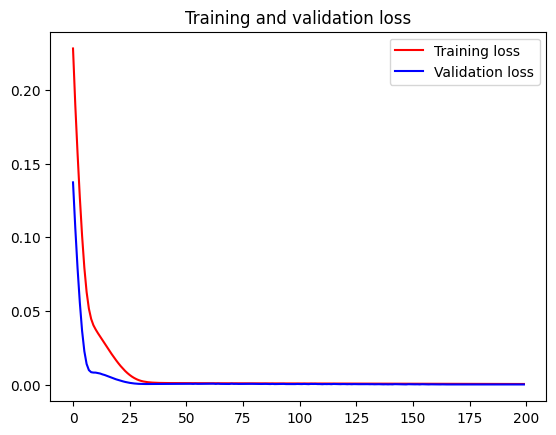

<Figure size 640x480 with 0 Axes>

14/14 [==============================] - 0s 2ms/step


((1020, 1), (437, 1))

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

Model Evaluation

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

Evaluation metrices RMSE, MSE and MAE

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1331.415894027333
Train data MSE:  1772668.2828686023
Train data MAE:  858.8200697856313
-------------------------------------------------------------------------------------
Test data RMSE:  726.7291668272427
Test data MSE:  528135.2819174184
Test data MAE:  515.975100979119


Variance Regression Score

In [ ]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9940516489027977
Test data explained variance regression score: 0.9913436430157496


R square score for regression

In [ ]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9940516489027977
Test data explained variance regression score: 0.9913436430157496
Train data R2 score: 0.9939180413120247
Test data R2 score: 0.9909134180586467


Comparision of original Bitcoin close price and predicted close price

In [ ]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1461, 1)
Test predicted data:  (1461, 1)


Time Step: 1
14/14 [==============================] - 0s 2ms/step
Minimum Test RMSE for Time Step 1: 709.7739185084032
Time Step: 2
14/14 [==============================] - 0s 2ms/step
Minimum Test RMSE for Time Step 2: 780.1802781650705
Time Step: 3
14/14 [==============================] - 0s 2ms/step
Minimum Test RMSE for Time Step 3: 764.4802207289644
Time Step: 4
14/14 [==============================] - 0s 2ms/step
Minimum Test RMSE for Time Step 4: 778.1412379634603
Time Step: 5
14/14 [==============================] - 0s 2ms/step
Minimum Test RMSE for Time Step 5: 735.0539274271797
Time Step: 6
14/14 [==============================] - 0s 2ms/step
Minimum Test RMSE for Time Step 6: 918.6537610692222
Time Step: 7
14/14 [==============================] - 0s 4ms/step
Minimum Test RMSE for Time Step 7: 726.6111102945915
Time Step: 8
14/14 [==============================] - 0s 3ms/step
Minimum Test RMSE for Time Step 8: 724.3574336672059
Time Step: 9
14/14 [============================

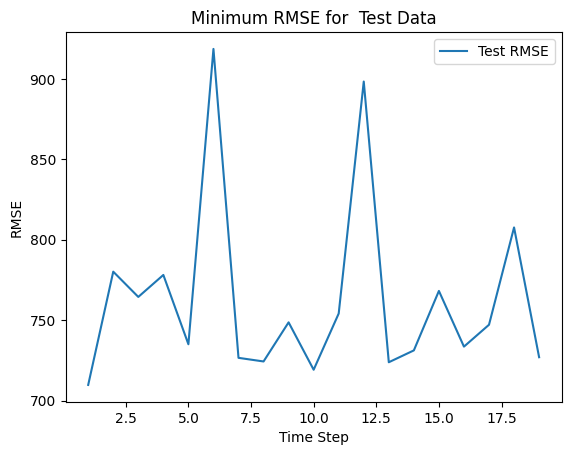

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Définir les valeurs de time_step à tester
time_steps = range(1, 20)

# Charger et prétraiter vos données (train_data, test_data, scaler)
# À compléter

# Stocker les résultats (RMSE minimum) pour chaque time_step
min_rmse_per_time_step = {}

for time_step in time_steps:
    print(f"Time Step: {time_step}")
    min_rmse = float('inf')  # Initialiser le minimum RMSE
    best_model = None  # Garder une trace du meilleur modèle

    for _ in range(2):  # Faire 2 exécutions pour chaque time_step
        # Créer les ensembles d'entraînement et de test avec le time_step actuel
        X_train, y_train = create_dataset(train_data, time_step)
        X_test, y_test = create_dataset(test_data, time_step)

        # Réorganiser les données pour LSTM
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        # Construire le modèle LSTM
        model = Sequential()
        model.add(LSTM(10, input_shape=(None, 1), activation="relu"))
        model.add(Dense(1))
        model.compile(loss="mean_squared_error", optimizer="adam")
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=0)

        # Prédire sur les ensembles d'entraînement et de test
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # Transformer les prédictions en valeurs originales
        train_predict = scaler.inverse_transform(train_predict)
        test_predict = scaler.inverse_transform(test_predict)
        original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
        original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculer RMSE pour les ensembles d'entraînement et de test
        train_rmse = mean_squared_error(original_ytrain, train_predict, squared=False)
        test_rmse = mean_squared_error(original_ytest, test_predict, squared=False)

        # Mettre à jour le minimum RMSE
        if test_rmse < min_rmse:
            min_rmse = test_rmse
            best_model = model

    # Stocker le minimum RMSE pour ce time_step
    min_rmse_per_time_step[time_step] = min_rmse

    # Afficher les résultats de chaque time_step
    print(f"Minimum Test RMSE for Time Step {time_step}: {min_rmse}")

# Trouver le time_step avec le minimum RMSE global
best_time_step = min(min_rmse_per_time_step, key=min_rmse_per_time_step.get)
print(f"Best Time Step: {best_time_step}, Minimum Test RMSE: {min_rmse_per_time_step[best_time_step]}")

# Initialiser les listes pour stocker les RMSE de l'ensemble d'entraînement et de l'ensemble de test
train_rmse_list = []
test_rmse_list = []

# Parcourir les résultats pour chaque time_step
for time_step in time_steps:
    # Récupérer le minimum RMSE pour cet time_step
    min_rmse = min_rmse_per_time_step[time_step]

    # Ajouter le minimum RMSE de l'ensemble d'entraînement et de l'ensemble de test aux listes correspondantes
    train_rmse_list.append(min_rmse)
    test_rmse_list.append(min_rmse)

# Tracer les RMSE de l'ensemble d'entraînement et de l'ensemble de test en fonction du time_step

plt.plot(time_steps, test_rmse_list, label='Test RMSE')
plt.xlabel('Time Step')
plt.ylabel('RMSE')
plt.title('Minimum RMSE for  Test Data')
plt.legend()
plt.show()

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 2
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  2


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[17 18]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 2 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='next 2 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## I. B. ARIMA

B.1. Choix des paramétres du modéle ARIMA - TimeStep : 1 Jour

In [ ]:
# Chargement des données
df = pd.read_csv('/content/BTC-USD (1).csv', parse_dates=['Date'], index_col='Date')
# Réduire la taille de la DataFrame pour accélérer le processus
df = df.iloc[1504:2964]

# Définition des plages des paramètres p, d, q à tester
p = d = q = range(0, 3)  # Exemple: tester de 0 à 2 pour chaque paramètre
pdq_combinations = list(product(p, d, q))  # Crée toutes les combinaisons possibles de p, d, q

# Initialisation pour suivre le meilleur modèle et son AIC
best_aic = np.inf
best_pdq = None
best_model = None

# Boucle sur toutes les combinaisons de paramètres pour trouver le meilleur modèle
for combination in pdq_combinations:
    try:
        # Ajustement du modèle ARIMA avec la combinaison courante
        model = ARIMA(df['Close'], order=combination)
        model_fit = model.fit()

        # Mise à jour du meilleur modèle si l'AIC est inférieur
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = combination
            best_model = model_fit
    except Exception as e:
        continue

# Affichage des paramètres optimaux et de l'AIC du meilleur modèle
print(f"Meilleur modèle ARIMA{best_pdq} avec AIC: {best_aic}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Meilleur modèle ARIMA(2, 1, 2) avec AIC: 24713.24000174623


B.2. Courbe de la variation de la moyenne mobile et d'écart type mobile - TimeStep : 1 Jour

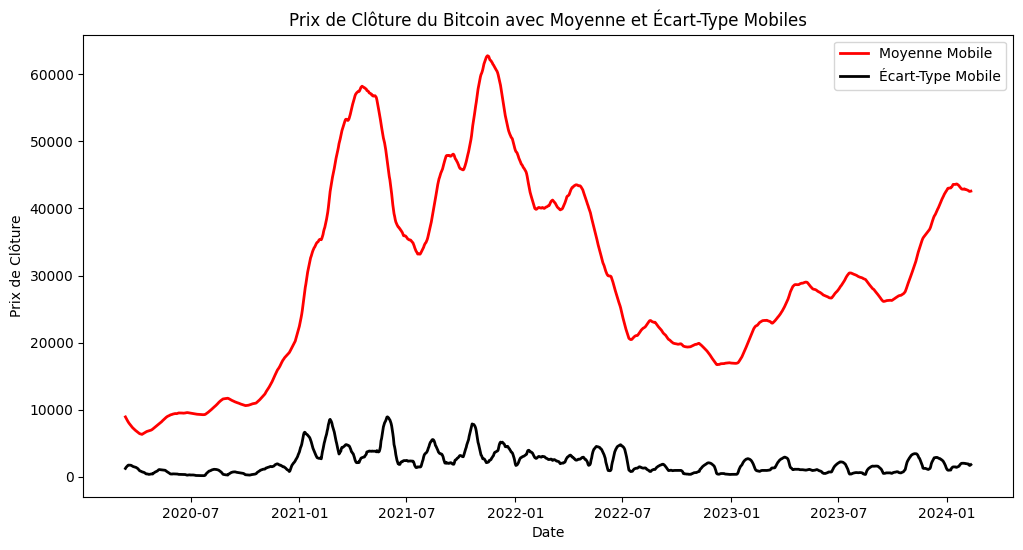

In [ ]:
# Sélection de la colonne 'Close' pour l'analyse
x = df['Close']

# Définir la taille de la fenêtre pour le calcul des statistiques mobiles
window_size = 30  # Exemple : fenêtre de 30 périodes

# Calcul de la moyenne mobile sur la fenêtre spécifiée
rolling_mean = x.rolling(window=window_size).mean()

# Calcul de l'écart-type mobile sur la même fenêtre
rolling_std = x.rolling(window=window_size).std()

# Tracer les statistiques mobiles
plt.figure(figsize=(12, 6))
plt.plot(rolling_mean, label='Moyenne Mobile', color='red', linewidth=2)
plt.plot(rolling_std, label='Écart-Type Mobile', color='black', linewidth=2)
plt.title('Prix de Clôture du Bitcoin avec Moyenne et Écart-Type Mobiles')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.show()

B.3. Courbe de la variation de la moyenne mobile et d'ecart type mobile aprés une transformation logarithmique des données - TimeStep : 1 Jour

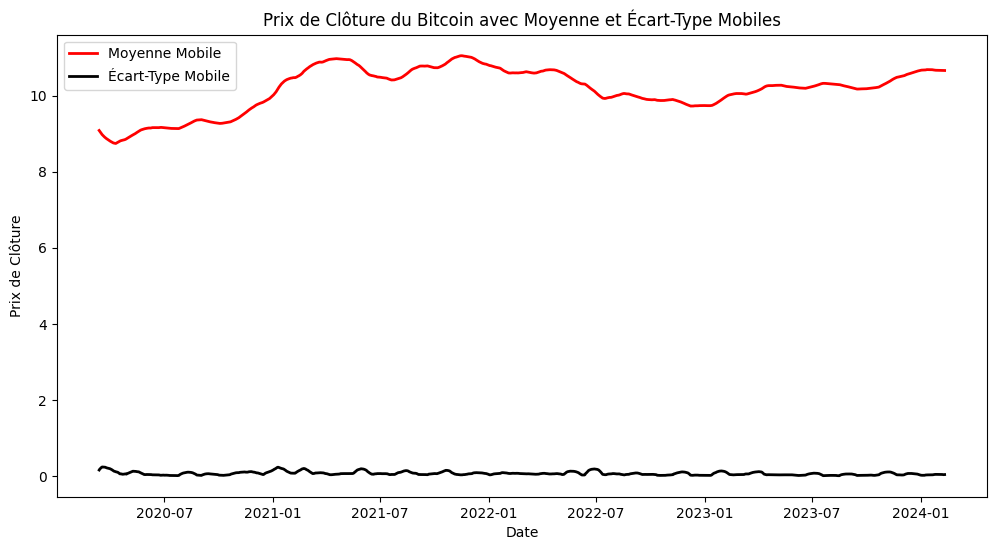

In [ ]:
# Sélection de la colonne 'Close' pour l'analyse
x = np.log(df['Close'])


# Définir la taille de la fenêtre pour le calcul des statistiques mobiles
window_size = 30  # Exemple : fenêtre de 30 périodes

# Calcul de la moyenne mobile sur la fenêtre spécifiée
rolling_mean = x.rolling(window=window_size).mean()

# Calcul de l'écart-type mobile sur la même fenêtre
rolling_std = x.rolling(window=window_size).std()

# Tracer les statistiques mobiles
plt.figure(figsize=(12, 6))
plt.plot(rolling_mean, label='Moyenne Mobile', color='red', linewidth=2)
plt.plot(rolling_std, label='Écart-Type Mobile', color='black', linewidth=2)
plt.title('Prix de Clôture du Bitcoin avec Moyenne et Écart-Type Mobiles')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.show()

B.4. Prediction du prix de cloture par le modéle ARIMA - TimeStep : 1 Jour

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Test MSE: 553357.831
Test RMSE: 743.880
R-squared value: 0.9874006505961138
[27594.74740137092, 28296.188838703158, 28411.690332192964, 29393.15631614595, 29354.36107109238, 29338.22785052977, 29330.248963202986, 28090.435916745224, 28615.29565538114, 28929.628105625667, 28771.006318855092, 29607.409219606026, 29110.890476680306, 28443.862140704012, 27653.13975335372, 27622.29216369236, 27640.379969878224, 27068.216563941547, 26840.2947354896, 26752.337554617112, 26830.21393027418, 27158.332397083646, 27080.093998112425, 27470.33412337548, 26749.34240549075, 26853.131929942465, 27064.478461107006, 26641.03138002629, 26903.916610161472, 27264.359871404242, 26343.880063643464, 26436.370119454004, 26579.907063619983, 26836.40470916143, 28099.793269036603, 27778.274906188883, 27717.212330673417, 27213.924905183165, 26808.44938247732, 27230.26161982945, 27075.929241254835, 27136.955275726334, 25808.230941168487, 27212.14163222022, 26311.0562587663, 26493.678564152873, 26503.848777548214, 25

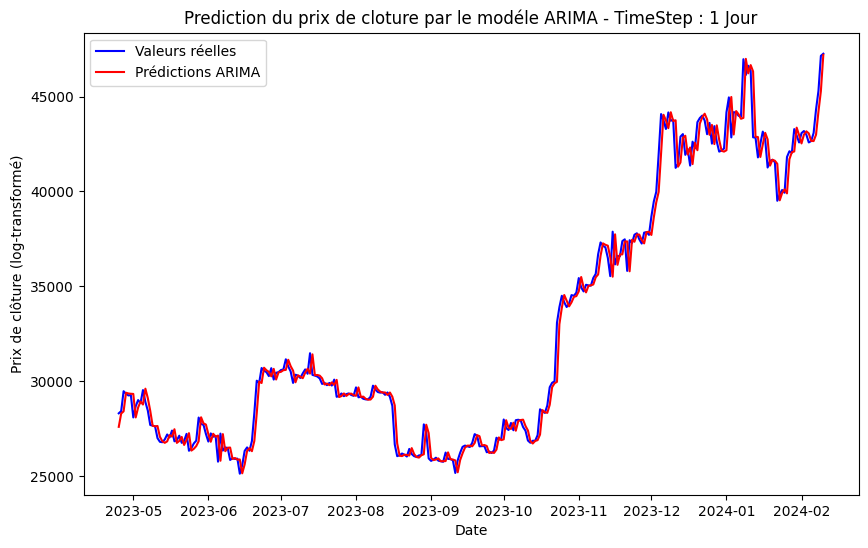

In [ ]:
# Chargement des données
df = pd.read_csv('/content/BTC-USD (1).csv', parse_dates=['Date'], index_col='Date')
# Réduire la taille de la DataFrame pour accélérer le processus
df = df.iloc[1504:2964]
# Définition des paramètres du modèle ARIMA
p = 2  # Ordre du composant AR (Autorégressif)
d = 1  # Ordre de différenciation (Intégré)
q = 2  # Ordre du composant MA (Moyenne Mobile)

# Division des données en ensembles d'entraînement et de test
train_size = int(len(df) * 0.8)
train, test = df['Close'][0:train_size], df['Close'][train_size:len(df)]

history = [x for x in train]  # Historique des observations pour l'entraînement itératif
predictions = []  # Pour stocker les prédictions

# Prédictions en marchant à travers le temps dans l'ensemble de test
for t in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])  # Ajouter l'observation réelle pour la prochaine itération

# Évaluation de la performance du modèle
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
r_squared = r2_score(test, predictions)

# Affichage des métriques de performance
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print("R-squared value:", r_squared)
print(predictions)
# Visualisation des valeurs réelles vs prédictions
plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='Valeurs réelles', color='blue')
plt.plot(test.index, predictions, label='Prédictions ARIMA', color='red')
plt.legend()
plt.title('Prediction du prix de cloture par le modéle ARIMA - TimeStep : 1 Jour')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.show()

In [ ]:
print(len(df))

1459


B.5. Prediction du prix de cloture par le modéle ARIMA aprés transformation logarithmique des données (time step un jour)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Test MSE: 0.000
Test RMSE: 0.021
R-squared value: 0.9879719236889212


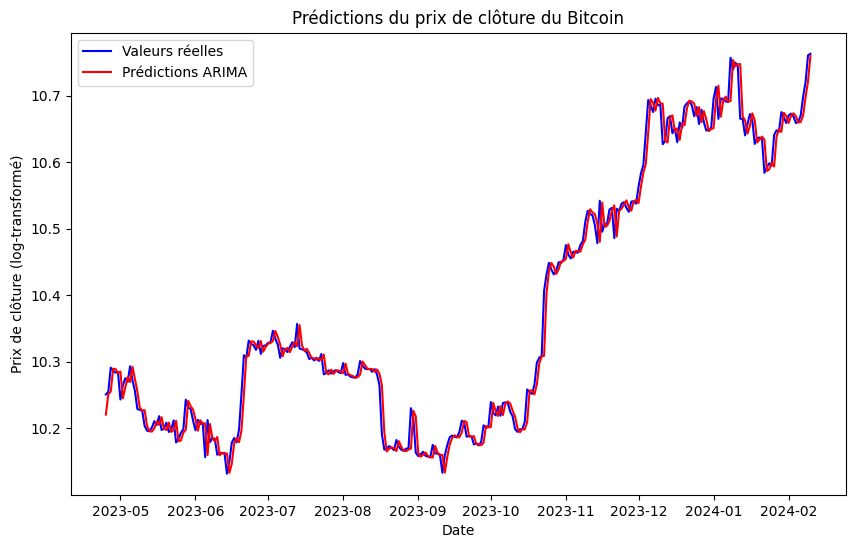

In [ ]:
# Chargement des données
df = pd.read_csv('/content/BTC-USD (1).csv', parse_dates=['Date'], index_col='Date')
# Réduire la taille de la DataFrame pour accélérer le processus
df = df.iloc[1504:2964]
# Définition des paramètres du modèle ARIMA
p = 2  # Ordre du composant AR (Autorégressif)
d = 1  # Ordre de différenciation (Intégré)
q = 2  # Ordre du composant MA (Moyenne Mobile)
df['Close'] = np.log(df['Close'])
# Division des données en ensembles d'entraînement et de test
train_size = int(len(df['Close']) * 0.8)
train, test = df['Close'][0:train_size], df['Close'][train_size:len(df)]

history = [x for x in train]  # Historique des observations pour l'entraînement itératif
predictions = []  # Pour stocker les prédictions

# Prédictions en marchant à travers le temps dans l'ensemble de test
for t in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])  # Ajouter l'observation réelle pour la prochaine itération

# Évaluation de la performance du modèle
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
r_squared = r2_score(test, predictions)

# Affichage des métriques de performance
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print("R-squared value:", r_squared)

# Visualisation des valeurs réelles vs prédictions
plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='Valeurs réelles', color='blue')
plt.plot(test.index, predictions, label='Prédictions ARIMA', color='red')
plt.legend()
plt.title('Prédictions du prix de clôture du Bitcoin')
plt.xlabel('Date')
plt.ylabel('Prix de clôture (log-transformé)')
plt.show()


B.6. Prediction du prix de cloture du Bitcoin en utilisant le modéle ARIMA - TimeStep : 1 Heure

In [ ]:
# Charger les données
df = pd.read_csv('/content/stock_data4.csv', parse_dates=['Datetime'], index_col='Datetime')
df = df.iloc[:1500]

# Définition des paramètres du modèle ARIMA
p = 2  # Ordre du composant AR (Autorégressif)
d = 1  # Ordre de différenciation (Intégré)
q = 2  # Ordre du composant MA (Moyenne Mobile)

# Division des données en ensembles d'entraînement et de test
train_size = int(len(df) * 0.8)
train, test = df['Close'][0:train_size], df['Close'][train_size:len(df)]

history = [x for x in train]  # Historique des observations pour l'entraînement itératif
predictions = []  # Pour stocker les prédictions

# Prédictions en marchant à travers le temps dans l'ensemble de test
for t in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])  # Ajouter l'observation réelle pour la prochaine itération

# Évaluation de la performance du modèle
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
r_squared = r2_score(test, predictions)

# Affichage des métriques de performance
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print("R-squared value:", r_squared)

# Visualisation des valeurs réelles vs prédictions
plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='Valeurs réelles', color='blue')
plt.plot(test.index, predictions, label='Prédictions ARIMA', color='red')
plt.legend()
plt.title('Prediction du prix de cloture du Bitcoin en utilisant le modéle ARIMA - TimeStep : 1 Heure')
plt.xlabel('Date')
plt.ylabel('Prix de clôture (log-transformé)')
plt.show()

NameError: name 'pd' is not defined